In [1]:
# 라이브러리 임포트
import requests
import pprint
import json
import pandas as pd
pd.set_option("display.max_columns", 100)
import os
from datetime import date, timedelta, datetime
from dotenv import load_dotenv
load_dotenv()
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns
from ydata_profiling import ProfileReport

In [2]:
# 데이터 불러오기
bike_info = pd.read_csv('./raw_data/seoul_bike_info.csv')
bike_usage_df = pd.read_csv('./raw_data/seoul_bike_usage.csv')
hot_places_df = pd.read_csv('./raw_data/bike_station_hot_places.csv')
# june = pd.read_csv('./raw_data/rental_history_raw_2024-01-01-2024-06-30.csv')
weather = pd.read_csv('./raw_data/kma_weather_2024.csv')

In [3]:
# 데이터 불러오기
# july = pd.read_csv('./raw_data/rental_history_raw_2024-07-01-2024-07-31.csv')
autumn = pd.read_csv('./raw_data/rental_history_raw_2024-08-01-2024-08-31.csv')
septamber = pd.read_csv('./raw_data/rental_history_raw_2024-09-01-2024-09-30.csv')
# october = pd.read_csv('./raw_data/rental_history_raw_2024-10-01-2024-10-31.csv')
# november = pd.read_csv('./raw_data/rental_history_raw_2024-11-01-2024-11-30.csv')
# december = pd.read_csv('./raw_data/rental_history_raw_2024-12-01-2024-12-31.csv')

In [4]:
concat_df = [autumn, septamber]
rental_2024 = pd.concat(concat_df, axis=0)
# test.to_csv('./div_data/rental_2024.csv', sep=',', encoding='utf-8', index=False)

### 데이터 전처리

In [5]:
# rental_2024 = pd.read_csv('./div_data/rental_2024.csv')

In [6]:
# 필요 컬럼 선정
anal_col = ['RNUM', 'BIKE_ID', 'RENT_DT', 'RTN_DT', 'USE_MIN', 'USE_DST']
anal_df = rental_2024[anal_col]
anal_df.head()

,RNUM,BIKE_ID,RENT_DT,RTN_DT,USE_MIN,USE_DST
0,1,SPB-50363,2024-08-01 00:00:54,2024-08-01 00:00:57,0,0.0
1,2,SPB-34202,2024-08-01 00:00:34,2024-08-01 00:01:05,0,0.0
2,3,SPB-66205,2024-08-01 00:00:30,2024-08-01 00:01:23,0,20.0
3,4,SPB-51876,2024-08-01 00:00:38,2024-08-01 00:01:31,0,0.0
4,5,SPB-50363,2024-08-01 00:01:53,2024-08-01 00:02:03,0,0.0


In [7]:
# 날짜 변환
def convert_date_rental(df):
    df['RENT_DT'] = pd.to_datetime(df['RENT_DT'])
    df['RTN_DT'] = pd.to_datetime(df['RTN_DT'])
    df["hour"]=df["RENT_DT"].dt.hour  
    df["month"]=df["RENT_DT"].dt.month
    df["day"]=df["RENT_DT"].dt.day
    df['dayofweek'] = df['RENT_DT'].dt.dayofweek
    df['month_start'] = df['RENT_DT'].dt.is_month_start
    df['woy'] = df['RENT_DT'].dt.isocalendar().week.astype(int)
    
    return df
    
anal_df = convert_date_rental(anal_df)

/var/folders/87/48zl7qwj6t5bwzfgff57cn540000gn/T/ipykernel_67892/2041811041.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['RENT_DT'] = pd.to_datetime(df['RENT_DT'])
/var/folders/87/48zl7qwj6t5bwzfgff57cn540000gn/T/ipykernel_67892/2041811041.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['RTN_DT'] = pd.to_datetime(df['RTN_DT'])
/var/folders/87/48zl7qwj6t5bwzfgff57cn540000gn/T/ipykernel_67892/2041811041.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a Dat

In [8]:
# 대여 ID(rental_id) 컬럼 생성(PK Key)
anal_df['rental_id'] = anal_df['month'].astype(str) + '-' + anal_df['day'].astype(str) + '-' + anal_df['RNUM'].astype(str)
anal_df.drop(columns='RNUM', inplace=True)
anal_df.head()

/var/folders/87/48zl7qwj6t5bwzfgff57cn540000gn/T/ipykernel_67892/1574073586.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  anal_df['rental_id'] = anal_df['month'].astype(str) + '-' + anal_df['day'].astype(str) + '-' + anal_df['RNUM'].astype(str)
/var/folders/87/48zl7qwj6t5bwzfgff57cn540000gn/T/ipykernel_67892/1574073586.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  anal_df.drop(columns='RNUM', inplace=True)


,BIKE_ID,RENT_DT,RTN_DT,USE_MIN,USE_DST,hour,month,day,dayofweek,month_start,woy,rental_id
0,SPB-50363,2024-08-01 00:00:54,2024-08-01 00:00:57,0,0.0,0,8,1,3,True,31,8-1-1
1,SPB-34202,2024-08-01 00:00:34,2024-08-01 00:01:05,0,0.0,0,8,1,3,True,31,8-1-2
2,SPB-66205,2024-08-01 00:00:30,2024-08-01 00:01:23,0,20.0,0,8,1,3,True,31,8-1-3
3,SPB-51876,2024-08-01 00:00:38,2024-08-01 00:01:31,0,0.0,0,8,1,3,True,31,8-1-4
4,SPB-50363,2024-08-01 00:01:53,2024-08-01 00:02:03,0,0.0,0,8,1,3,True,31,8-1-5


### 데이터 기반으로 그룹 기준 설정

In [9]:
# 이동 시간과 이동 거리의 기본 통계량 확인
anal_df[['USE_MIN', 'USE_DST']].describe().T

,count,mean,std,min,25%,50%,75%,max
USE_MIN,8507897.0,20.437832,30.143620,0.0,5.00,10.00,24.0,3714.00
USE_DST,8507897.0,2237.937879,3018.528969,0.0,731.58,1284.79,2430.0,188330.66


In [10]:
import numpy as np
# Z-score 이상치 제거
out_df = anal_df[np.abs(anal_df["USE_MIN"]-anal_df["USE_MIN"].mean())<=(3*anal_df["USE_MIN"].std())]
anal_df2 = out_df[np.abs(out_df["USE_DST"]-out_df["USE_DST"].mean())<=(3*out_df["USE_DST"].std())] 
print ("Shape Of The Before Ouliers: ",anal_df.shape)
print ("Shape Of The After Ouliers: ",anal_df2.shape)

Shape Of The Before Ouliers:  (8507897, 12)
Shape Of The After Ouliers:  (8172998, 12)


In [11]:
# 이상치 제거 후 이동 시간과 이동 거리의 기본 통계량 확인
anal_df2[['USE_MIN', 'USE_DST']].describe().T

,count,mean,std,min,25%,50%,75%,max
USE_MIN,8172998.0,17.068609,19.195364,0.0,5.00,10.00,21.0000,110.00
USE_DST,8172998.0,1842.673726,1847.478545,0.0,717.22,1238.42,2251.1075,10533.71


In [12]:
# 중앙값 및 상위 25% 계산
distance_median = anal_df2['USE_DST'].median()
distance_75th = anal_df2['USE_DST'].quantile(0.75)

duration_median = anal_df2['USE_MIN'].median()
duration_75th = anal_df2['USE_MIN'].quantile(0.75)

print(f"중앙값 기준: 거리={distance_median}m, 시간={duration_median}분")
print(f"상위 25% 기준: 거리={distance_75th}m, 시간={duration_75th}분")

중앙값 기준: 거리=1238.42m, 시간=10.0분
상위 25% 기준: 거리=2251.1075m, 시간=21.0분


- 자전거 ID를 무작위로 나누어 실험군과 통제군을 설정

In [13]:
import time
from sklearn.model_selection import train_test_split
# 실행 시간 측정 시작
start_time = time.time()

# 고유한 BIKE_ID 추출
bike_ids = anal_df2['BIKE_ID'].unique()

# 실험군과 통제군으로 분리
experiment_bikes, control_bikes = train_test_split(bike_ids, test_size=0.5, random_state=42)

# 그룹 매핑 생성
bike_group_mapping = {bike_id: 'experiment' if bike_id in experiment_bikes else 'control' for bike_id in bike_ids}

# 그룹 할당 (map 사용)
anal_df2['group'] = anal_df2['BIKE_ID'].map(bike_group_mapping)

# 실행 시간 측정 종료
end_time = time.time()

# 실행 시간 출력
execution_time = end_time - start_time
print(f"Execution Time: {execution_time} seconds")

Execution Time: 36.211913108825684 seconds


/var/folders/87/48zl7qwj6t5bwzfgff57cn540000gn/T/ipykernel_67892/2178119266.py:16: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  anal_df2['group'] = anal_df2['BIKE_ID'].map(bike_group_mapping)


### 주요 지표 설정

- 대여 횟수 변화
    * 월별 대여 횟수

In [18]:
anal_df2.head()

,BIKE_ID,RENT_DT,RTN_DT,USE_MIN,USE_DST,hour,month,day,dayofweek,month_start,woy,rental_id,group
0,SPB-50363,2024-08-01 00:00:54,2024-08-01 00:00:57,0,0.0,0,8,1,3,True,31,8-1-1,control
1,SPB-34202,2024-08-01 00:00:34,2024-08-01 00:01:05,0,0.0,0,8,1,3,True,31,8-1-2,control
2,SPB-66205,2024-08-01 00:00:30,2024-08-01 00:01:23,0,20.0,0,8,1,3,True,31,8-1-3,experiment
3,SPB-51876,2024-08-01 00:00:38,2024-08-01 00:01:31,0,0.0,0,8,1,3,True,31,8-1-4,control
4,SPB-50363,2024-08-01 00:01:53,2024-08-01 00:02:03,0,0.0,0,8,1,3,True,31,8-1-5,control


In [14]:
# (가정) 9월 실험군 자전거 대여 횟수 10% 증가

# 그룹별 일일 평균 대여 횟수 계산
monthly_rental = anal_df2.groupby(['group', 'BIKE_ID', 'month'])['rental_id'].count().reset_index()
monthly_rental.columns = ['group', 'BIKE_ID', 'month', 'total_rentals']
monthly_rental.loc[
    (monthly_rental['group'] == 'experiment') & (monthly_rental['month'] == 9), 'total_rentals'
] *= 1.1

# 그룹별 월평균 대여 횟수 계산
avg_rentals = monthly_rental.groupby(['group', 'month'])['total_rentals'].mean().reset_index()
avg_rentals.columns = ['group', 'month', 'avg_rentals']

/var/folders/87/48zl7qwj6t5bwzfgff57cn540000gn/T/ipykernel_67892/404577180.py:6: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise an error in a future version of pandas. Value '[108.9 170.5 101.2 ...  51.7   8.8  13.2]' has dtype incompatible with int64, please explicitly cast to a compatible dtype first.
  monthly_rental.loc[


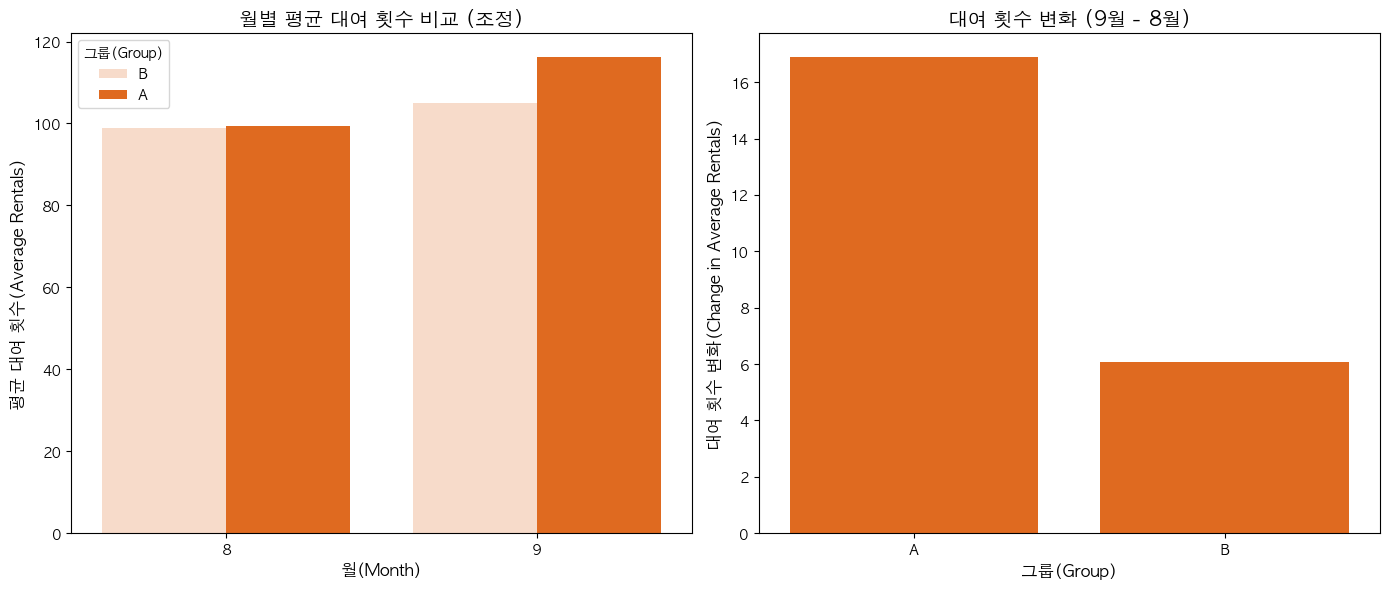

In [28]:
import warnings
warnings.filterwarnings('ignore')
from matplotlib import rc
rc('font', family='AppleGothic')  
plt.rcParams['axes.unicode_minus'] = False  # 마이너스 기호 깨짐 방지
# 색상 설정
custom_color = '#FF6300'

# 그래프 생성
fig, ax = plt.subplots(1, 2, figsize=(14, 6))

# (왼쪽) 월별 평균 대여 횟수 비교
sns.barplot(
    x='month', 
    y='avg_rentals', 
    hue='group', 
    data=avg_rentals, 
    ax=ax[0], 
    palette=['#FFD9C2', custom_color]  # 실험군: FF6300, 통제군: 연한 주황색
)
ax[0].set_title('월별 평균 대여 횟수 비교 (조정)', fontsize=14)
ax[0].set_xlabel('월(Month)', fontsize=12)
ax[0].set_ylabel('평균 대여 횟수(Average Rentals)', fontsize=12)
ax[0].legend(title='그룹(Group)', fontsize=10)

# (오른쪽) 대여 횟수 변화 비교
change_in_rentals = avg_rentals.pivot(index='group', columns='month', values='avg_rentals')
change_in_rentals['Change'] = change_in_rentals[9] - change_in_rentals[8]
sns.barplot(
    x=change_in_rentals.index, 
    y=change_in_rentals['Change'], 
    ax=ax[1], 
    color=custom_color  # 단일 색상: FF6300
)
ax[1].set_title('대여 횟수 변화 (9월 - 8월)', fontsize=14)
ax[1].set_xlabel('그룹(Group)', fontsize=12)
ax[1].set_ylabel('대여 횟수 변화(Change in Average Rentals)', fontsize=12)

# 전체 레이아웃 조정
plt.tight_layout()
plt.show()



In [24]:
# AB 그룹 정의
monthly_rental["group"] = np.where(monthly_rental.group == "experiment", "A", "B")
monthly_rental.head()

,group,BIKE_ID,month,total_rentals
0,B,SPB-30006,8,82.0
1,B,SPB-30006,9,70.0
2,B,SPB-30010,8,69.0
3,B,SPB-30010,9,69.0
4,B,SPB-30018,8,93.0


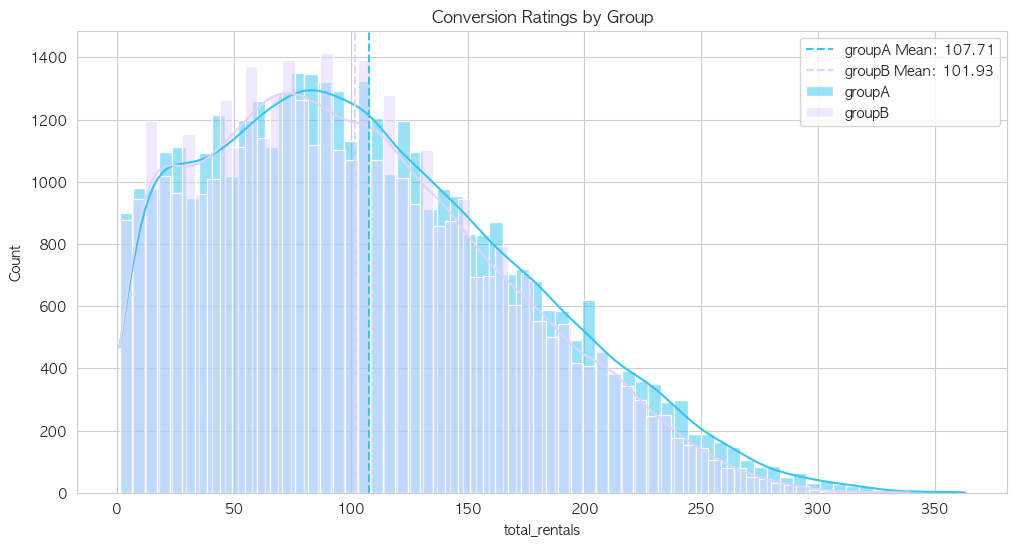

# A/B Testing Hypothesis
H0: A == B
H1: A != B 



,Test Type,AB Hypothesis,p-value,Cohen's d,Comment
0,Non-Parametric,Reject H0,5.679061e-26,0.089161,A/B groups are not similar!


In [58]:
# A/B Testing Function 수정
def AB_Test(dataframe, group, target):
    from scipy.stats import shapiro
    import scipy.stats as stats
    
    # Split A/B
    groupA = dataframe[dataframe[group] == "A"][target]
    groupB = dataframe[dataframe[group] == "B"][target]
    
    # Assumption: Normality
    ntA = shapiro(groupA)[1] < 0.05
    ntB = shapiro(groupB)[1] < 0.05
    
    if (ntA == False) & (ntB == False): 
        leveneTest = stats.levene(groupA, groupB)[1] < 0.05
        
        if leveneTest == False:
            ttest = stats.ttest_ind(groupA, groupB, equal_var=True)[1]
        else:
            ttest = stats.ttest_ind(groupA, groupB, equal_var=False)[1]
    else:
        ttest = stats.mannwhitneyu(groupA, groupB)[1]
    
    # 시각화 함수
    def get_kde(groupA, groupB):
        mean1 = np.mean(groupA)
        mean2 = np.mean(groupB)
        plt.figure(figsize=(12, 6))
        sns.histplot(groupA, color="#35C5F0", label='groupA', kde=True)
        sns.histplot(groupB, color="#E1D2FF", label='groupB', kde=True)
        plt.axvline(mean1, color='#35C5F0', linestyle='--', label=f'groupA Mean: {mean1:.2f}')
        plt.axvline(mean2, color='#E1D2FF', linestyle='--', label=f'groupB Mean: {mean2:.2f}')
        plt.legend()
        plt.title("Conversion Ratings by Group")
        plt.show()
    
    get_kde(groupA, groupB)
    
    # Cohen's d 계산 함수
    def cohen_d(groupA, groupB):
        # 평균 계산
        mean1 = np.mean(groupA)
        mean2 = np.mean(groupB)
        
        # 공통 표준편차 계산
        pooled_std = np.sqrt(((len(groupA) - 1) * np.std(groupA, ddof=1)**2 + 
                            (len(groupB) - 1) * np.std(groupB, ddof=1)**2) / 
                            (len(groupA) + len(groupB) - 2))
        
        # Cohen's d 계산
        d = (mean1 - mean2) / pooled_std
        return d
    
    # Cohen's d 계산
    cohen_d_value = cohen_d(groupA, groupB)
    
    # Result DataFrame 생성
    temp = pd.DataFrame({
        "AB Hypothesis":[ttest < 0.05], 
        "p-value":[ttest],
        "Cohen's d":[cohen_d_value]
    })
    
    temp["Test Type"] = np.where((ntA == False) & (ntB == False), "Parametric", "Non-Parametric")
    temp["AB Hypothesis"] = np.where(temp["AB Hypothesis"] == False, "Fail to Reject H0", "Reject H0")
    temp["Comment"] = np.where(temp["AB Hypothesis"] == "Fail to Reject H0", "A/B groups are similar!", "A/B groups are not similar!")
    
    if (ntA == False) & (ntB == False):
        temp["Homogeneity"] = np.where(leveneTest == False, "Yes", "No")
        temp = temp[["Test Type", "Homogeneity", "AB Hypothesis", "p-value", "Cohen's d", "Comment"]]
    else:
        temp = temp[["Test Type", "AB Hypothesis", "p-value", "Cohen's d", "Comment"]]
    
    print("# A/B Testing Hypothesis")
    print("H0: A == B")
    print("H1: A != B", "\n")
    
    return temp

# A/B Testing 실행
ab_result = AB_Test(dataframe=monthly_rental, group="group", target="total_rentals")
ab_result


Font 'default' does not have a glyph for '\u2212' [U+2212], substituting with a dummy symbol.
Font 'default' does not have a glyph for '\u2212' [U+2212], substituting with a dummy symbol.
Font 'default' does not have a glyph for '\u2212' [U+2212], substituting with a dummy symbol.
Font 'default' does not have a glyph for '\u2212' [U+2212], substituting with a dummy symbol.
Font 'default' does not have a glyph for '\u2212' [U+2212], substituting with a dummy symbol.
Font 'default' does not have a glyph for '\u2212' [U+2212], substituting with a dummy symbol.
Font 'default' does not have a glyph for '\u2212' [U+2212], substituting with a dummy symbol.
Font 'default' does not have a glyph for '\u2212' [U+2212], substituting with a dummy symbol.
Font 'default' does not have a glyph for '\u2212' [U+2212], substituting with a dummy symbol.
Font 'default' does not have a glyph for '\u2212' [U+2212], substituting with a dummy symbol.
Font 'default' does not have a glyph for '\u2212' [U+2212], 

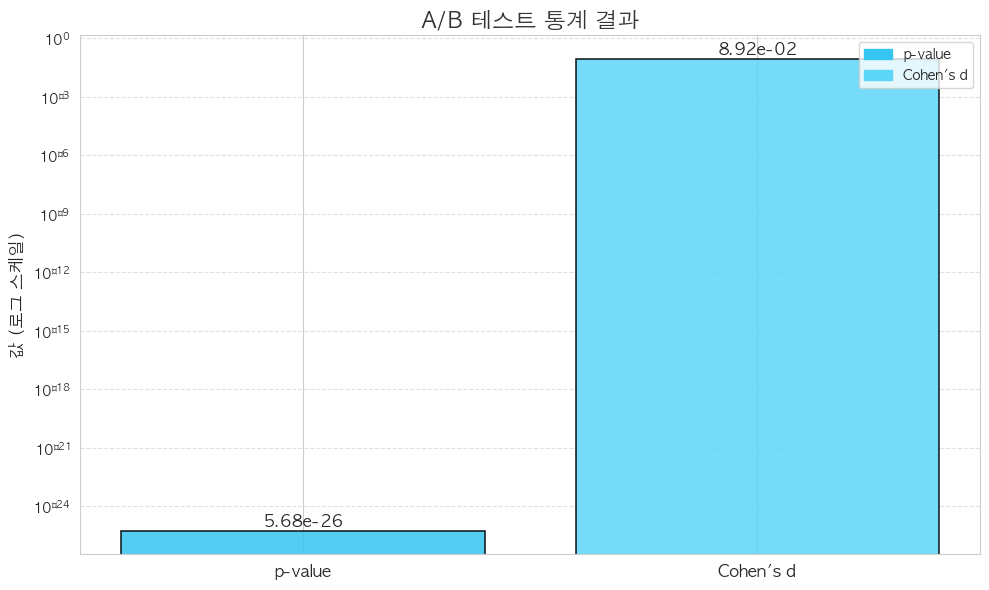

In [57]:
rc('font', family='AppleGothic')  
plt.rcParams['axes.unicode_minus'] = False  # 마이너스 기호 깨짐 방지

# 데이터
metrics = ['p-value', "Cohen's d"]
values = ab_result[metrics].values.flatten()

# 그래프 생성
plt.figure(figsize=(10, 6))
bars = plt.bar(metrics, values, color=['#35C5F0', '#5DD5F8'], alpha=0.85, edgecolor='black', linewidth=1.2)

# 값 표시
for bar in bars:
    yval = bar.get_height()
    plt.text(bar.get_x() + bar.get_width()/2, yval * 1.5, f'{yval:.2e}', ha='center', fontsize=12, fontweight='bold')

# 그래프 꾸미기
plt.yscale('log')  # p-value 값이 작으므로 로그 스케일 사용
plt.ylabel('값 (로그 스케일)', fontsize=12, fontweight='bold')
plt.title('A/B 테스트 통계 결과', fontsize=16, fontweight='bold', color='#333333')
plt.xticks(fontsize=12, fontweight='bold')
plt.yticks(fontsize=10)
plt.grid(axis='y', linestyle='--', alpha=0.6)

# 범례 추가
colors = {'p-value': '#35C5F0', "Cohen's d": '#5DD5F8'}
labels = list(colors.keys())
handles = [plt.Rectangle((0, 0), 1, 1, color=colors[label]) for label in labels]
plt.legend(handles, labels, loc='upper right', fontsize=10)

# 그래프 출력
plt.tight_layout()
plt.show()


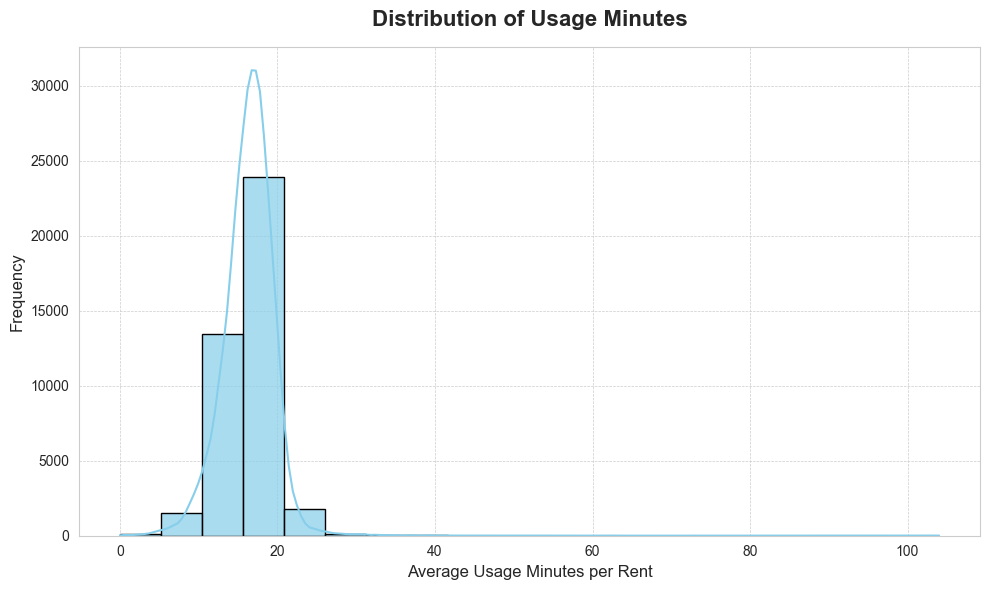

In [32]:
# 이용자 자전거 평균 이용 시간(분)

# Seaborn 스타일 설정
sns.set_style('whitegrid')  # 배경 스타일
sns.set_palette('pastel')   # 색상 팔레트

# 데이터 그룹화 및 평균 계산
df = anal_df2.groupby('BIKE_ID')['USE_MIN'].mean().reset_index()

# 히스토그램 생성
plt.figure(figsize=(10, 6))  # 그래프 크기 설정
sns.histplot(data=df, x='USE_MIN', kde=True, bins=20, color='skyblue', edgecolor='black', alpha=0.7)

# 그래프 제목 및 라벨 추가
plt.title('Distribution of Usage Minutes', fontsize=16, fontweight='bold', pad=15)
plt.xlabel('Average Usage Minutes per Rent', fontsize=12)
plt.ylabel('Frequency', fontsize=12)

# x축과 y축 눈금 크기 설정
plt.xticks(fontsize=10)
plt.yticks(fontsize=10)

# 그리드 추가 및 저장 옵션
plt.grid(visible=True, which='major', linestyle='--', linewidth=0.5)
plt.tight_layout()  # 레이아웃 조정
plt.show()


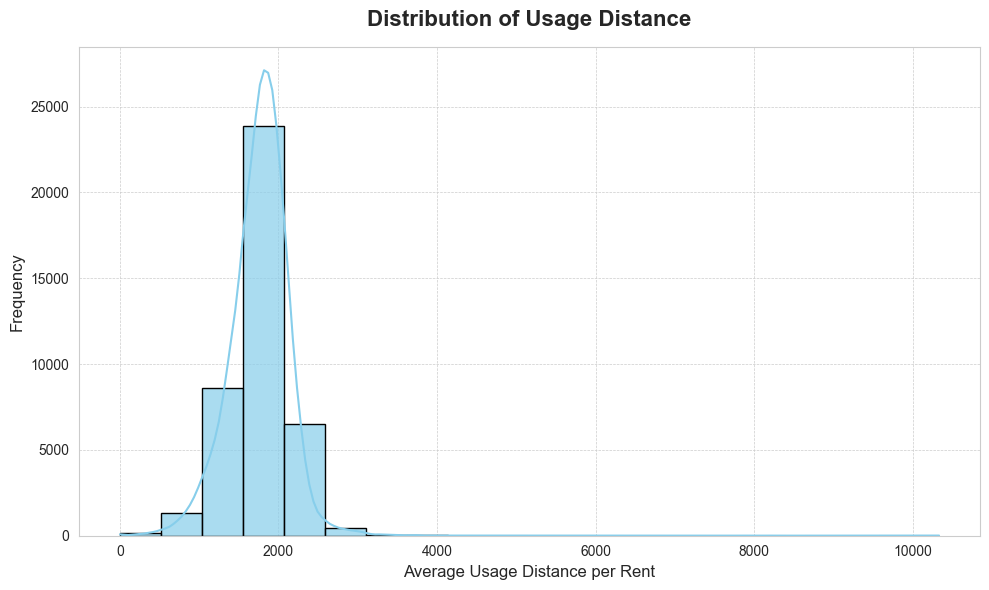

In [33]:
# 이용자 자전거 평균 거리(m)

# Seaborn 스타일 설정
sns.set_style('whitegrid')  # 배경 스타일
sns.set_palette('pastel')   # 색상 팔레트

# 데이터 그룹화 및 평균 계산
df = anal_df2.groupby('BIKE_ID')['USE_DST'].mean().reset_index()

# 히스토그램 생성
plt.figure(figsize=(10, 6))  # 그래프 크기 설정
sns.histplot(data=df, x='USE_DST', kde=True, bins=20, color='skyblue', edgecolor='black', alpha=0.7)

# 그래프 제목 및 라벨 추가
plt.title('Distribution of Usage Distance', fontsize=16, fontweight='bold', pad=15)
plt.xlabel('Average Usage Distance per Rent', fontsize=12)
plt.ylabel('Frequency', fontsize=12)

# x축과 y축 눈금 크기 설정
plt.xticks(fontsize=10)
plt.yticks(fontsize=10)

# 그리드 추가 및 저장 옵션
plt.grid(visible=True, which='major', linestyle='--', linewidth=0.5)
plt.tight_layout()  # 레이아웃 조정
plt.show()
